### [Grover's Algorithm](https://arxiv.org/abs/quant-ph/0005055) 

---

Grover’s algorithm is a pivotal development in quantum computing, representing a special case of a quantum algorithm known as Amplitude Amplification. <br> In this demo, you will learn its basic principles and how to implement it in PennyLane. Additionally, we will discuss a valuable extension of the algorithm called fixed-point amplitude amplification.

In this tutorial, we are going to implement a search for an n-bit string
item using a quantum circuit based on Grover\'s Algorithm.

The algorithm can be broken down into the following steps:

1.  Prepare the initial state
2.  Implement the Oracle
3.  Apply the Grover diffusion operator
4.  Repeat steps 2 and 3 approximately $\frac{\pi}{4}\sqrt{N}$ times
5.  Measure

#### Prepare Initial state

To perform the search, we are going to create an n-dimensional system,
which has $N = 2^n$ computational basis states, represented via $N$
binary numbers. More specifically, bit strings with length $n$, labelled
as $x_0,x_2,\cdots, x_{N-1}$. We initialize the system in the uniform
superposition over all states, i.e., the amplitudes associated with each
of the $N$ basis states are equal:

$$|s\rangle ={\frac {1}{\sqrt {N}}}\sum _{x=0}^{N-1}|x\rangle .$$

This can be achieved by applying a Hadamard gate to all the wires. We
can inspect the circuit using [Snapshot](https://docs.pennylane.ai/en/stable/code/api/pennylane.Snapshot.html#pennylane.Snapshot) to see how the states change on each step. Let us check
the probability of finding a state in the computational basis for a
2-qubit circuit, writing the following functions and QNodes:


In [62]:
import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np

NUM_QUBITS = 2
dev = qml.device("default.qubit", wires=NUM_QUBITS)
wires = list(range(NUM_QUBITS))


def equal_superposition(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)


@qml.qnode(dev)
def circuit():
    qml.Snapshot("Initial state")  # capture the state at thast moment 
    equal_superposition(wires)
    qml.Snapshot("After applying the Hadamard gates")
    return qml.probs(wires=wires)  # Probability of finding a computational basis state on the wires


results = qml.snapshots(circuit)() ## this will return a dictionary with the snapshots we did in the circuit

for k, result in results.items():
    print(f"{k}: {result}")

Initial state: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
After applying the Hadamard gates: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
execution_results: [0.25 0.25 0.25 0.25]


Let’s use a bar plot to better visualize the initial state amplitudes:

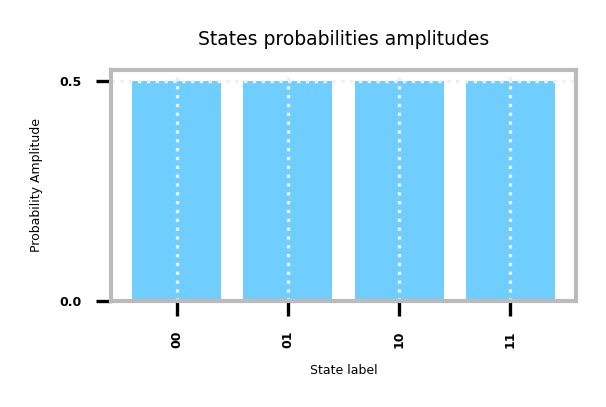

In [63]:
y = np.real(results["After applying the Hadamard gates"])
bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

plt.figure(figsize=(2, 1))
plt.bar(bit_strings, y, color = "#70CEFF")

plt.xticks(fontsize=14)  # Set the font size for x-axis tick labels
plt.yticks(fontsize=3)  # Set the font size for y-axis tick labels
plt.xticks(rotation="vertical", fontsize=3)
plt.xlabel("State label", fontsize=3)
plt.ylabel("Probability Amplitude",fontsize=3)
plt.title("States probabilities amplitudes", fontsize=4.5)
plt.show()

As expected, they are equally distributed.

The Oracle and Grover\'s diffusion operator
===========================================

Let\'s assume for now that only one index satisfies $f(x) = 1$. We are
going to call this index $\omega$. To access $f(x)$ with an Oracle, we
can formulate a unitary operator such that

$$\begin{aligned}
\begin{cases}
U_{\omega }|x\rangle =-|x\rangle &{\text{for }}x=\omega {\text{, that is, }}f(x)=1,\\U_{\omega }|x\rangle =|x\rangle &{\text{for }}x\neq \omega {\text{, that is, }}f(x)=0,
\end{cases}
\end{aligned}$$

where and $U_\omega$ acts by flipping the phase of the solution state
while keeping the remaining states untouched. In other words, the
unitary $U_\omega$ can be seen as a reflection around the set of
orthogonal states to $\vert \omega \rangle$, written as

$$U_\omega = \mathbb{I} - 2\vert \omega \rangle \langle \omega \vert.$$

This can be easily implemented with
[FlipSign](https://docs.pennylane.ai/en/stable/code/api/pennylane.FlipSign.html#pennylane.FlipSign), which takes a
binary array and flips the sign of the corresponding state.

Let us take a look at an example. If we pass the array `[0,0]`, the sign
of the state
$\vert 00 \rangle = \begin{bmatrix} 1 \\0 \\0 \\0 \end{bmatrix}$ will
flip:


Initial state |00>: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
After flipping it: [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]
execution_results: [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]


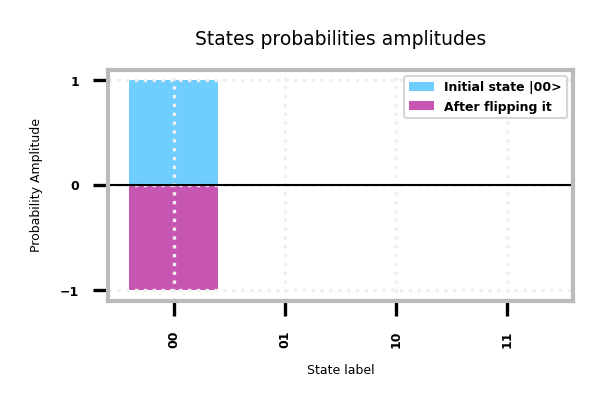

In [64]:
dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    qml.Snapshot("Initial state |00>")
    # Flipping the marked state
    qml.FlipSign([0, 0], wires=wires)
    qml.Snapshot("After flipping it")
    return qml.state()

results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

y1 = np.real(results["Initial state |00>"])
y2 = np.real(results["After flipping it"])


bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]
plt.figure(figsize=(2, 1))
plt.yticks(fontsize=3)  # Set the font size for y-axis tick labels
plt.bar(bit_strings, y1, color = "#70CEFF")
plt.bar(bit_strings, y2, color = "#C756B2")

plt.xticks(rotation="vertical", fontsize=3)
plt.xlabel("State label", fontsize=3)
plt.ylabel("Probability Amplitude", fontsize=3)
plt.title("States probabilities amplitudes", fontsize=4.5)

plt.legend(["Initial state |00>", "After flipping it"], fontsize = 3)
plt.axhline(y=0.0, color="k", linestyle="-", linewidth=0.5)
plt.show()




We can see that the amplitude of the state $\vert 01\rangle$ flipped.
Now, let us prepare the Oracle and inspect its action in the circuit.


In [69]:
omega = np.zeros(NUM_QUBITS)

def oracle(wires, omega):
    qml.FlipSign(omega, wires=wires)

dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    equal_superposition(wires)
    qml.Snapshot("Before querying the Oracle")

    oracle(wires, omega)
    qml.Snapshot("After querying the Oracle")

    return qml.probs(wires=wires)

results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Before querying the Oracle: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
After querying the Oracle: [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
execution_results: [0.25 0.25 0.25 0.25]


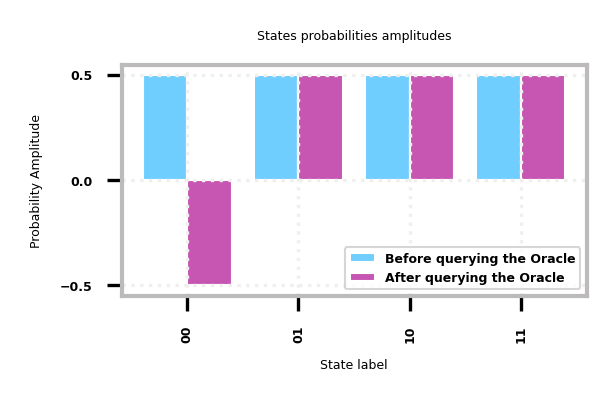

In [71]:
y1 = np.real(results["Before querying the Oracle"])
y2 = np.real(results["After querying the Oracle"])

bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y1))]

bar_width = 0.4

rect_1 = np.arange(0, len(y1))
rect_2 = [x + bar_width for x in rect_1]

plt.figure(figsize=(2, 1))
plt.bar(
    rect_1,
    y1,
    width=bar_width,
    edgecolor="white",
    color = "#70CEFF",
    label="Before querying the Oracle",
)
plt.bar(
    rect_2,
    y2,
    width=bar_width,
    edgecolor="white",
    color = "#C756B2",
    label="After querying the Oracle",
)
plt.yticks(fontsize = 3)
plt.xticks(rect_1 + 0.2, bit_strings, rotation="vertical",fontsize = 3)
plt.xlabel("State label",fontsize = 3)
plt.ylabel("Probability Amplitude",fontsize = 3)
plt.title("States probabilities amplitudes",fontsize = 3)

plt.legend(fontsize = 3)
plt.show()

We can see that the amplitude corresponding to the state
$\vert \omega \rangle$ changed. However, we need an additional step to
find the solution, since the probability of measuring any of the states
remains equally distributed. This can be solved by applying the *Grover
diffusion* operator, defined as

$$U_D = 2| s \rangle\langle s| - \mathbb{I}.$$

The unitary $U_D$ also acts as a rotation, but this time through the
uniform superposition $\vert s \rangle$. Finally, the combination of
$U_{\omega}$ with $U_D$ rotates the state $\vert s \rangle$ by an angle
of $\theta =2 \arcsin{\tfrac {1}{\sqrt {N}}}$. For more geometric
insights about the Oracle and the diffusion operator, please refer to
this [codebook section](https://codebook.xanadu.ai/G.2).

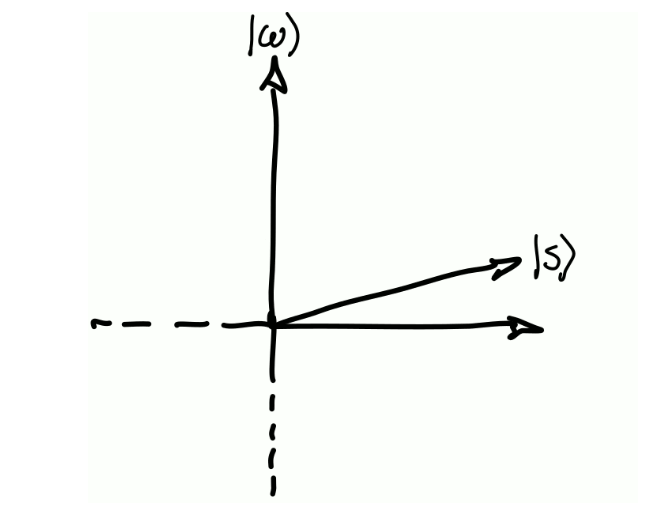

In a 2-qubit circuit, the diffusion operator has a specific shape:

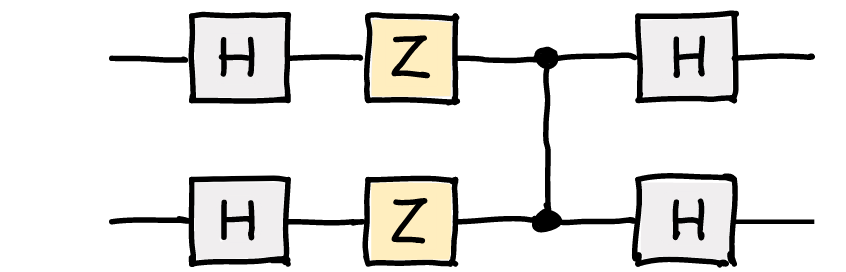

Now, we have all the building blocks to implement a single-item search
in a 2-qubit circuit. We can verify in the circuit below that applying
the *Grover iterator* $U_D U_\omega$ once is enough to solve the
problem.


Before querying the Oracle: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
After querying the Oracle: [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
execution_results: [0.25 0.25 0.25 0.25]


<Figure size 600x300 with 0 Axes>

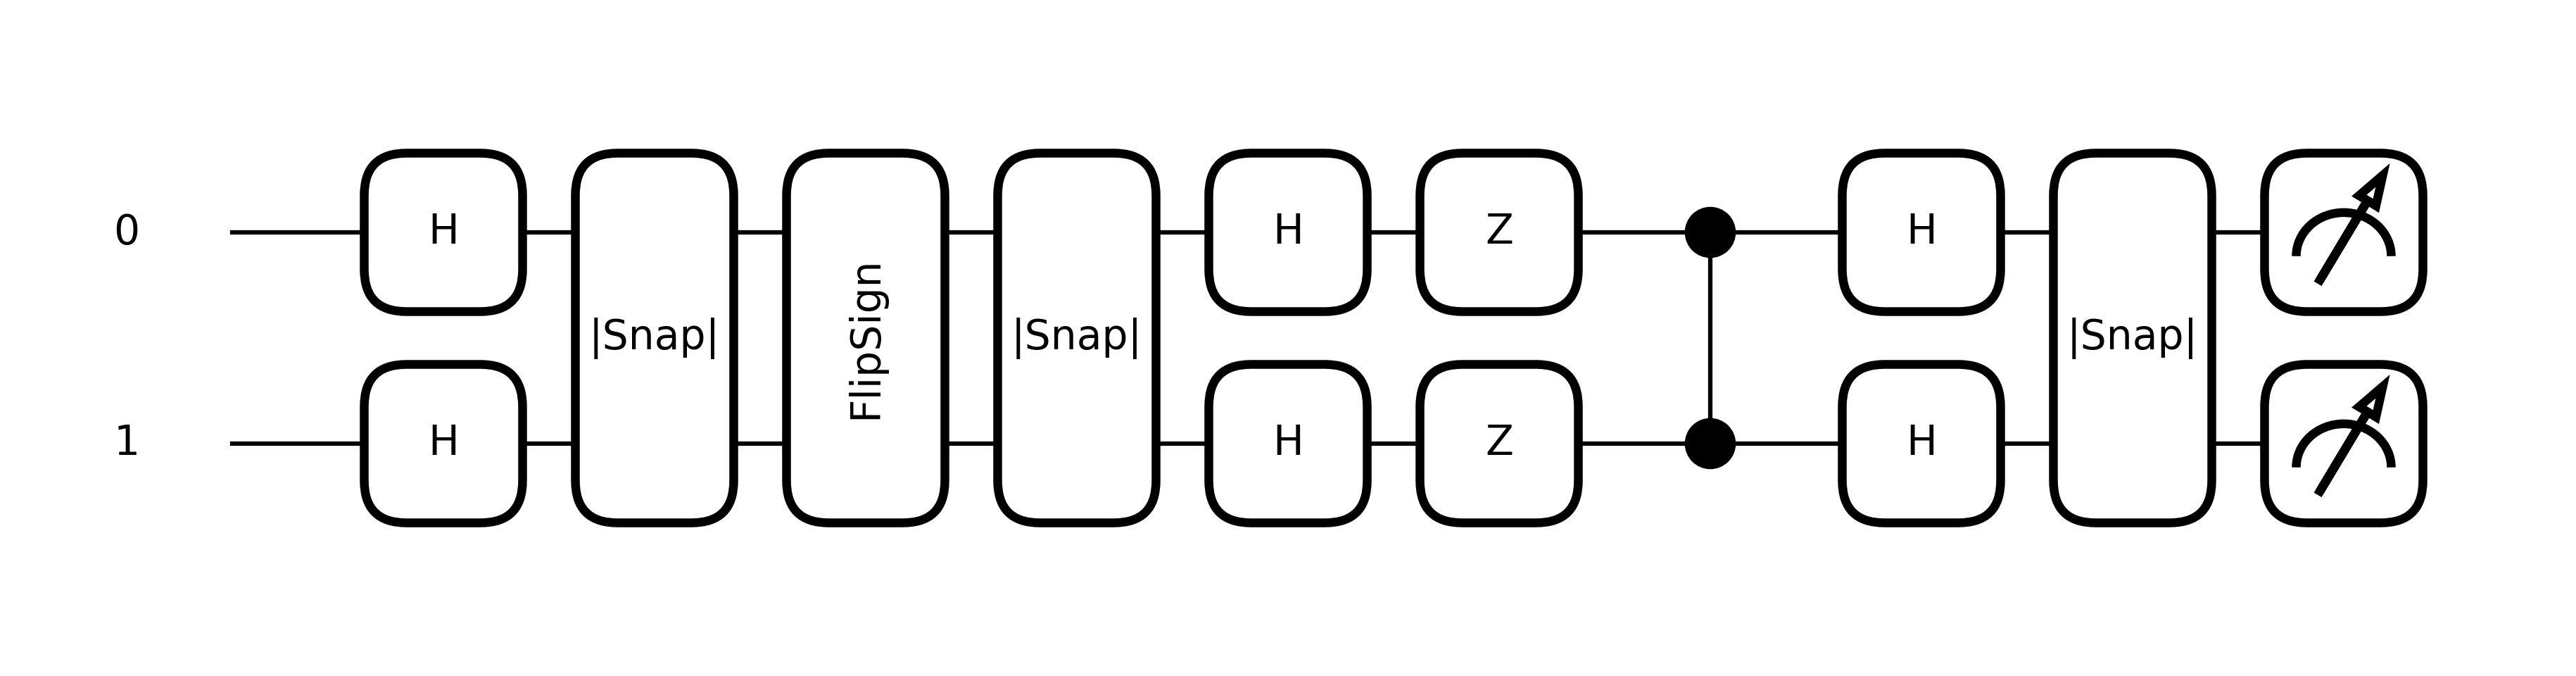

In [74]:
dev = qml.device("default.qubit", wires=NUM_QUBITS)


def diffusion_operator(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)
        qml.PauliZ(wires=wire)
    qml.ctrl(qml.PauliZ, 0)(wires=1)
    for wire in wires:
        qml.Hadamard(wires=wire)


@qml.qnode(dev)
def circuit():
    equal_superposition(wires)
    qml.Snapshot("Uniform superposition |s>")

    oracle(wires, omega)
    qml.Snapshot("State marked by Oracle")
    diffusion_operator(wires)

    qml.Snapshot("Amplitude after diffusion")
    return qml.probs(wires=wires)


# results = qml.snapshots(circuit)()
qml.draw_mpl(circuit)()  # Draw the circuit
for k, result in results.items():
    print(f"{k}: {result}")

Searching for more items in a bigger list
=========================================

Now, let us consider the generalized problem with large $N$, accepting
$M$ solutions, with $1 \leq M \leq N$. In this case, the optimal number
of Grover iterations to find the solution is given by
$r \approx \left \lceil \frac{\pi}{4} \sqrt{\frac{N}{M}} \right \rceil$.

For more qubits, we can use the same function for the Oracle to mark the
desired states, and the diffusion operator takes a more general form:

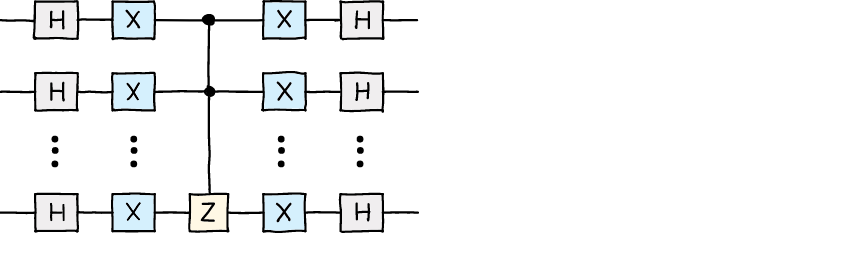

which is easily implemented using
[GroverOperator](https://docs.pennylane.ai/en/stable/code/api/pennylane.GroverOperator.html#pennylane.GroverOperator)

Finally, we have all the tools to build the circuit for Grover\'s
Algorithm, as we can see in the code below. For simplicity, we are going
to search for the states $\vert 0\rangle ^{\otimes n}$ and
$\vert 1\rangle ^{\otimes n}$, where $n = \log_2 N$ is the number of
qubits.


In [75]:
NUM_QUBITS = 5

omega = np.array([np.zeros(NUM_QUBITS), np.ones(NUM_QUBITS)])

M = len(omega)
N = 2**NUM_QUBITS
wires = list(range(NUM_QUBITS))

dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    iterations = int(np.round(np.sqrt(N / M) * np.pi / 4))

    # Initial state preparation
    equal_superposition(wires)

    # Grover's iterator
    for _ in range(iterations):
        for omg in omega:
            oracle(wires, omg)
        qml.templates.GroverOperator(wires)

    return qml.probs(wires=wires)


results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

execution_results: [0.48065948 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.48065948]


Let us use a bar plot to visualize the probability to find the correct
bitstring.


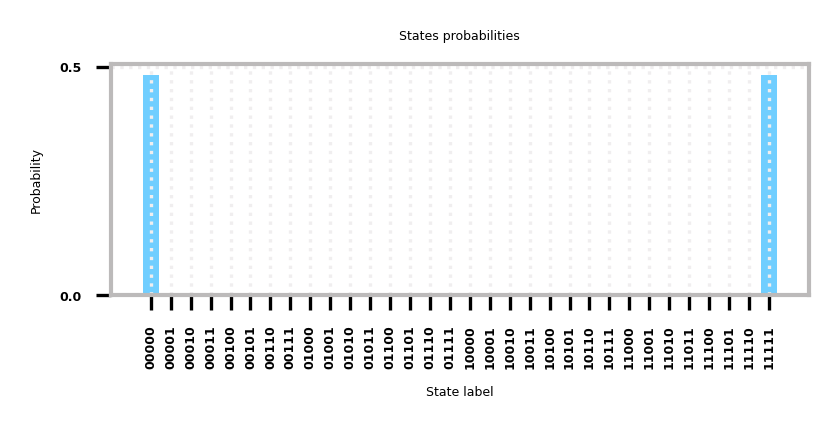

In [76]:
y = results["execution_results"]
bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

plt.figure(figsize=(3, 1))

plt.bar(bit_strings, results["execution_results"], color = "#70CEFF")
plt.yticks(fontsize = 3)
plt.xticks(rotation="vertical",fontsize = 3)
plt.xlabel("State label",fontsize = 3)
plt.ylabel("Probability",fontsize = 3)
plt.title("States probabilities",fontsize = 3)

plt.show()

Conclusion
==========

In conclusion, we have learned the basic steps of Grover\'s algorithm
and how to implement it to search $M$ items in a list of size $N$ with
high probability.